In [1]:
#Packages:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from camera_matrix import camera_matrix
import time
import seaborn as sns
import matplotlib.patches as mpatches

In [2]:
def save_BW_img(cap):
    image= []
    while True:
  # Lire l'image suivante de la vidéo
        ret, frame = cap.read()

  # Vérifier si la fin de la vidéo a été atteinte
        if not ret:
            break

  # Convertir l'image en noir et blanc
        img_gray= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        image.append(img_gray)
    cv2.destroyAllWindows()
    cap.release() 
    return image

In [3]:
def save_half_frames(images):
    selected_images = []
    for i in range(len(images)):
        if i % 2 == 0:
            selected_images.append(images[i])
    return selected_images

In [4]:
# Read a sequence of 2 stereoscopic images, synchronized (frame 107 to 131 for video 1, frame 45 to 69 for video 2)
#cap0 = cv2.VideoCapture("/Users/nilsmanni/Desktop/MA2/design_project/Design-Project/vid1_dx.MP4")
cap0 = cv2.VideoCapture("/Users/nilsmanni/Desktop/MA2/design_project/GX010031.MP4")
#cap0 = cv2.VideoCapture("/Users/nilsmanni/Desktop/MA2/design_project/GX010056.MP4")
#cap1 = cv2.VideoCapture("/Users/nilsmanni/Desktop/MA2/design_project/Design-Project/vid1_sx.MP4")

dx_images = save_BW_img(cap0)
dx_images = save_half_frames(dx_images)


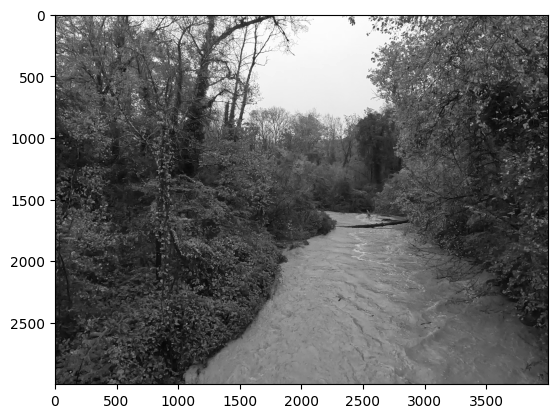

In [5]:
# Show two synchronized images
from PIL import Image
import matplotlib.pyplot as plt

image = dx_images[0]

plt.imshow(image, cmap='gray')

In [6]:
# Define the y-axis range
start_y = 2000
end_y = 2750

# define the x-axis range
start_x = 0
end_x = 4000
# Define the size of the stripe
stripe_height = end_y - start_y
stripe_width = end_x - start_x

dx_stripes = []

# Loop through the images and select the stripe for each image
for img in dx_images:
    # Convert the image to a numpy array
    img_array = np.array(img)

    # Select the stripe using array slicing
    selected_stripe = img_array[start_y:end_y, start_x:end_x]

    # Append the selected stripe to the list
    dx_stripes.append(selected_stripe)

# Now, 'stripes' is a list containing the selected stripes from each image

In [7]:
# Define the y-axis range
start_y = 2250
end_y = 2750

# define the x-axis range
start_x = 0
end_x = 4000
# Define the size of the stripe
stripe_height = end_y - start_y
stripe_width = end_x - start_x

dx_stripes = []

# Loop through the images and select the stripe for each image
for img in dx_images:
    # Convert the image to a numpy array
    img_array = np.array(img)

    # Select the stripe using array slicing
    selected_stripe = img_array[start_y:end_y, start_x:end_x]

    # Append the selected stripe to the list
    dx_stripes.append(selected_stripe)

# Now, 'stripes' is a list containing the selected stripes from each image

In [8]:
dx_stripes[0].shape[1]

4000

46


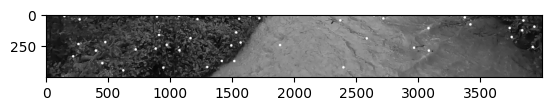

(<matplotlib.image.AxesImage at 0x14cc020a0>, None)

In [9]:
nb_points = 7
horizontal_band = 500
def keypoint(nb_points, image):
    keypoints = np.empty((0, 2), dtype=np.intp)
    for i in range (0,image.shape[1]-horizontal_band+1 ,horizontal_band):
        selected_stripe= image[:, i : i + horizontal_band]
        corners = cv2.goodFeaturesToTrack(selected_stripe, nb_points,0.5,70)
        corners = np.intp(corners.reshape(-1, 2))
        corners[:, 0] += i# ajouter i a la coordonnée x 
        keypoints = np.concatenate((keypoints, corners), axis=0)
    return keypoints # les paires de coordonnées de chaque keypoints

corners = keypoint(nb_points, dx_stripes[0])
print(len(corners))
img_circles = dx_stripes[0].copy()

for i in corners:
 x,y = i.ravel()
 cv2.circle(img_circles,(x,y),10,255,-1)
 
plt.imshow(img_circles, cmap='gray'),plt.show()

In [10]:
def NCC_window(x,y, image): # normalized cross correlation window of 9x9 around our pixel of 
    # Do not forget that if x0-4 or x0+5 is out of the image, we will not take into account this tracking point. 
    #NCC = image[y-4:y+5, x-4:x+5] # rows and columns are switched in the image ( image size is 750x1500)
    NCC = image[y-18:y+19, x-18:x+19]
    return NCC

In [11]:
def tracking(x0,y0,image, NCC):
    match = 0
    x1 = 0
    y1 = 0
    for x in range(x0-14, x0+14): 
        for y in range(y0-14, y0+14):
            img_comp = NCC_window(x,y,image)
            res = cv2.matchTemplate(img_comp,NCC, cv2.TM_CCORR_NORMED)
            if np.max(res) > match: 
                match = np.max(res)
                x1 = x
                y1 = y
    return(x1, y1)

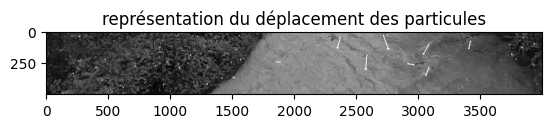

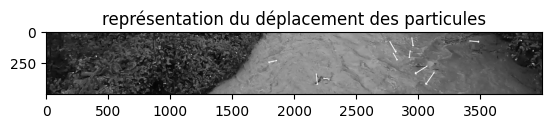

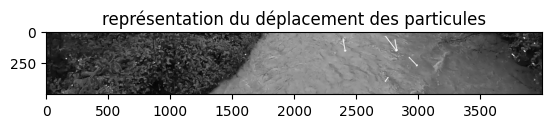

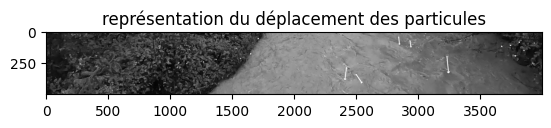

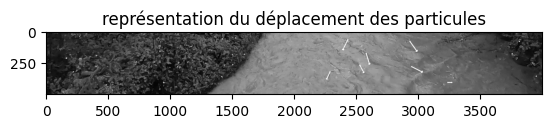

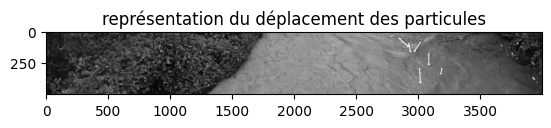

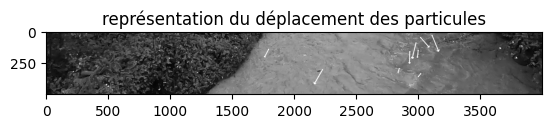

         x0     y0      x1     y1  direction     length
233  3021.0  339.0  3000.0  363.0  -0.718830  31.890437
234  3838.0  119.0  3840.0  120.0   1.107149   2.236068
235  3794.0  212.0  3797.0  215.0   0.785398   4.242641
236  3765.0   87.0  3769.0   89.0   1.107149   4.472136
237  3661.0  134.0  3666.0  138.0   0.896055   6.403124


In [14]:
stats = pd.DataFrame()
img_list=[]
for img_nb in range(0, len(dx_stripes)):
    if img_nb % 20 == 0 and img_nb + 13 < len(dx_stripes): # la deuxieme condition est nécessaire pour pouvoir analyser les images jusqu'à la fin de la video
        corners = keypoint(nb_points, dx_stripes[img_nb])
        coord_track = corners[:,:2].reshape(-1, 2)
        displacement = np.zeros((len(corners),12,2))
        point_i = 0
        point_delete = []
        for x,y in coord_track: 
            for i in range(img_nb + 1, img_nb + 13):
                if x< 32 or x > stripe_width-32 or y < 32 or y > stripe_height-32: 
                    #stock les points à enlever
                    point_delete= np.append(point_delete, point_i)
                    break #skip au prochain point
                NCC = NCC_window(x,y, dx_stripes[i-1])
                displacement[point_i, i-1-img_nb ,:]= x,y
                x,y = tracking(x,y, dx_stripes[i], NCC)
            point_i += 1
        point_delete= point_delete.astype(int)
        displacement = np.delete(displacement,point_delete,0 )
        img_circles = dx_stripes[img_nb].copy()

        direction = []
        length = []
        for j in range(displacement.shape[0]):
            x0,y0 = displacement[j,0,:]
            x1,y1 = displacement[j,11,:]
            # recupere angle et taille des vecteurs

            if y1-y0 == 0: #trouver le moyen d'élimier les vecteurs ou on divise par 0
                angle = np.nan
                intensity = np.nan
            else: 
                angle = np.arctan((x1-x0)/(y1-y0))
                intensity = np.sqrt((x1-x0)*(x1-x0) + (y1-y0)*(y1-y0))
            
            direction = np.append(direction, angle)
            length= np.append(length, intensity)

            # représente les vecteurs sur les images
            cv2.circle(img_circles,(int(x0),int(y0)),5,255,-1)
            cv2.circle(img_circles,(int(x1),int(y1)),5,(70,255,212),-1)
            cv2.arrowedLine(img_circles, (int(x0),int(y0)), (int(x1),int(y1)), 255, 6)

        x0 = displacement[:, 0, 0]
        y0 = displacement[:, 0, 1]
        x1 = displacement[:, 11, 0]
        y1 = displacement[:, 11, 1]

        stats_temp = pd.DataFrame({
            'x0': x0,
            'y0': y0,
            'x1': x1,
            'y1': y1,
            'direction': direction,
            'length': length
        })
        stats = pd.concat([stats, stats_temp], ignore_index=True)
        plt.title('représentation du déplacement des particules')
        plt.imshow(img_circles, cmap = 'gray'),plt.show()
        img_list.append(img_circles)
        
print(stats.tail())

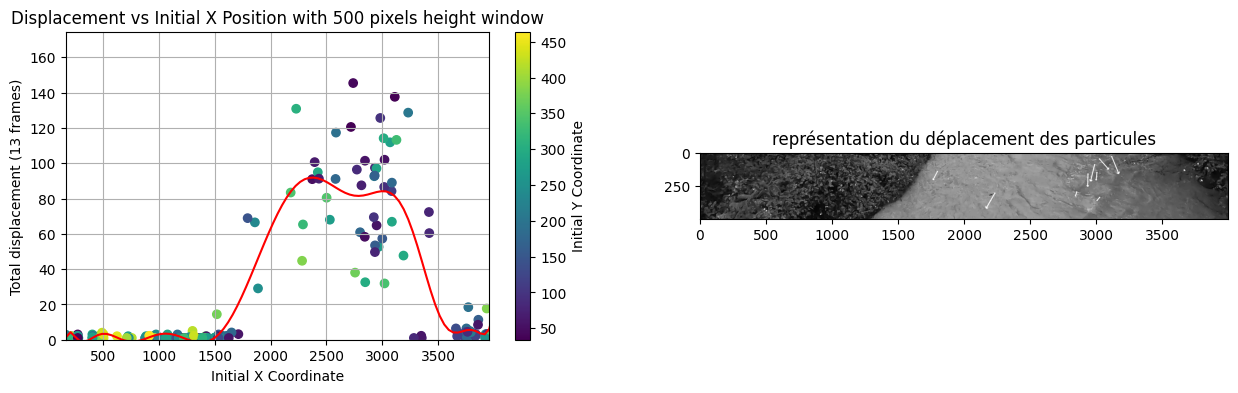

In [15]:
# Assuming 'displacement' is available from your code

stats = stats.dropna()
x = stats.x0
y = stats.length

mymodel = np.poly1d(np.polyfit(x, y, 16))
myline = np.linspace(5, 4000, 100)
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.scatter(x, y, c=stats.y0, cmap='viridis')
plt.plot(myline, mymodel(myline), color='red')
#plt.scatter(stats.x0, stats.length)
plt.xlabel("Initial X Coordinate")
plt.ylabel("Total displacement (13 frames)")
plt.title("Displacement vs Initial X Position with 500 pixels height window")
plt.colorbar(label='Initial Y Coordinate')
plt.ylim(bottom=0, top=np.max(y) + 0.2*np.max(y))
plt.xlim(left = np.min(x), right= np.max(x))
plt.grid(True)

# Affichage de la dernière image de img_list
plt.subplot(1, 2, 2)
plt.title('représentation du déplacement des particules')
plt.imshow(img_list[-1], cmap='gray')
plt.show() 

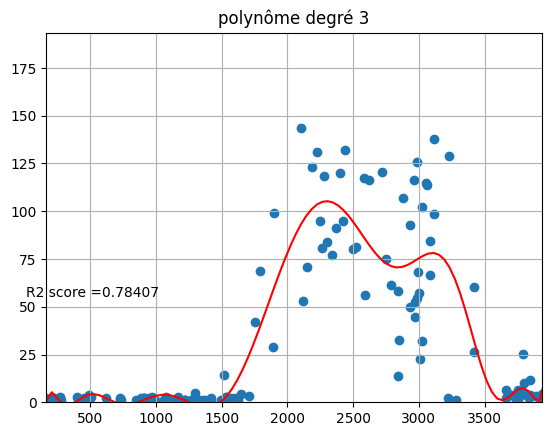

In [57]:
from sklearn.metrics import r2_score#pour calculer le coeff R2

x = stats.x0
y = stats.length

mymodel = np.poly1d(np.polyfit(x, y, 16))
myline = np.linspace(5, 4000, 100)

plt.title("polynôme degré 3")
plt.scatter(x, y)
plt.plot(myline, mymodel(myline), color='red')
#plt.text(12, 60, mymodel)
plt.text(12, 55, 'R2 score ={:.5f}'.format(r2_score(y, mymodel(x))))
plt.ylim(bottom=0, top=np.max(y) + 50)
plt.xlim(left = np.min(x), right= np.max(x))
plt.grid(True)

Comment réduire la std? 

    - prendre en compte les jeux de luminosité

    - prendre les angles par rapport au point de fuite. 

    - moyenene des vitesses transversales == 0

    - prendre des fenetres NCC plus grande (entre 30 et 50 pixels) ?

Questions: 
    - pour les cas ou le débit peut arriver a ± 5m/s il faut que la fenetre d'études fasse au moins 5m. Dans le cas de vid1 ca fait une fenêtre quand meme assez grande et le temps de calcul risque d'être assez long. 

In [14]:
display(stats[['direction', 'length']].describe()) #cv2.TM_CCOEFF_NORMED

,direction,length
count,231.000000,231.000000
mean,0.069008,119.034916
std,0.682880,43.306947
min,-1.498197,6.324555
25%,-0.535053,90.578827
50%,0.122337,124.531121
75%,0.638304,150.011526
max,1.552617,201.534116


In [15]:
display(stats[['direction', 'length']].describe()) #cv2.TM_SQDIFF_NORMED

,direction,length
count,231.000000,231.000000
mean,0.069008,119.034916
std,0.682880,43.306947
min,-1.498197,6.324555
25%,-0.535053,90.578827
50%,0.122337,124.531121
75%,0.638304,150.011526
max,1.552617,201.534116


In [16]:
display(stats[['direction', 'length']].describe()) #cv2.TM_CCORR_NORMED

,direction,length
count,231.000000,231.000000
mean,0.069008,119.034916
std,0.682880,43.306947
min,-1.498197,6.324555
25%,-0.535053,90.578827
50%,0.122337,124.531121
75%,0.638304,150.011526
max,1.552617,201.534116


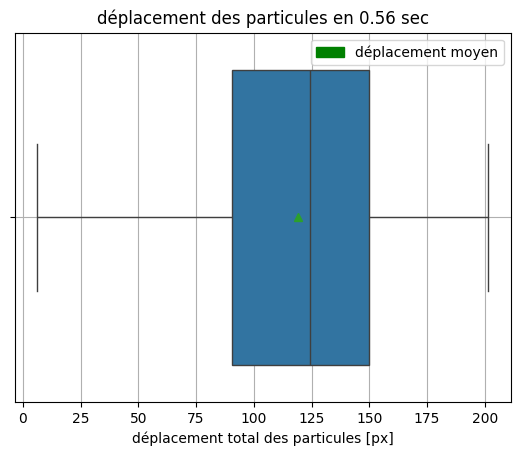

In [17]:
#boxplot= stats.boxplot(column = ['vertical_anlge'])
sns.boxplot(x="length", showmeans=True, data=stats)
#sns.despine(bottom=True)
mean_patch = mpatches.Patch(color='green', label='déplacement moyen')
plt.legend(handles=[mean_patch], loc='upper right')
plt.xlabel("déplacement total des particules [px]")
plt.title("déplacement des particules en 0.56 sec")
plt.grid(True)
plt.show()